# **Section B (Scratch Implementation)**

In [1]:
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from google.colab import drive
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

In [2]:
drive.mount('/content/drive')
path ='/content/drive/MyDrive/ML/Assignment_1/Heart Disease.csv'

Mounted at /content/drive


In [3]:
df = pd.read_csv(path)
df = df.dropna()
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HeartDisease
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [6]:
def min_max_scaler(X):
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

### Graph Function

In [7]:
def show(training_loss, validation_loss, training_accuracy, validation_accuracy, test_loss=None, test_accuracy=None):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label="Training Loss")
    plt.plot(validation_loss, label="Validation Loss")

    if test_loss is not None:
        plt.plot(test_loss, label="Test Loss", linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label="Training Accuracy")
    plt.plot(validation_accuracy, label="Validation Accuracy")

    if test_accuracy is not None:
        plt.plot(test_accuracy, label="Test Accuracy", linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


def add_labels(rectangles, ax):

        for rect in rectangles:
            ax.annotate(f'{rect.get_height():.3f}', xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


def show_metrics(early, no_early, labels):

    w = 0.25
    fig, ax = plt.subplots(figsize=(17, 8))

    ax.set_xlabel('Hyperparameter Combinations')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics with and without Early Stopping')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)

    add_labels(ax.bar(np.arange(len(labels)) - 1.5*w, early['accuracy'], w, label='Accuracy (No Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) - 0.5*w, no_early['accuracy'], w, label='Accuracy (Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 0.5*w, early['precision'], w, label='Precision (No Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 1.5*w, no_early['precision'], w, label='Precision (Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 2.5*w, early['recall'], w, label='Recall (No Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 3.5*w, no_early['recall'], w, label='Recall (Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 4.5*w, early['f1'], w, label='F1 Score (No Early)'), ax)
    add_labels(ax.bar(np.arange(len(labels)) + 5.5*w, no_early['f1'], w, label='F1 Score (Early)'), ax)
    ax.legend()

    fig.tight_layout()
    plt.show()

# **Main Logistic Regression Class**

In [8]:
class LogisticRegression():

    def __init__(self, alpha=0.001, epochs=100, init_weights_by="zeros", method="BGD", batch_size=32, verbose=False, patience=10, min_delta=0.001, early_stopping=False, regularization=None, lmbda=0.01, graphs = True):

        self.cnt = 0
        self.bias = 0
        self.y_pred = []
        self.weights = []
        self.lmbda = lmbda
        self.alpha = alpha
        self.graphs = graphs
        self.method = method
        self.epochs = epochs
        self.test_loss = None
        self.verbose = verbose
        self.training_loss = []
        self.patience = patience
        self.test_accuracy = None
        self.validation_loss = []
        self.min_delta = min_delta
        self.training_accuracy = []
        self.batch_size = batch_size
        self.best_loss = float('inf')
        self.validation_accuracy = []
        self.regularization = regularization
        self.early_stopping = early_stopping
        self.init_weights_by = init_weights_by


    def fit(self, X_train, y_train, X_val, y_val, X_test=None, y_test=None):

        if X_test is not None and y_test is not None:
            self.test_loss = []
            self.test_accuracy = []

        m, n = X_train.shape

        if self.init_weights_by == "random":
            self.weights = np.random.randn(n)

        else:
            self.weights = np.zeros(n)

        for i in range(self.epochs):
            if self.method == 'BGD':
                self.gradient_descent(X_train, y_train)

            elif self.method == 'SGD':
                self.stochastic_gradient_descent(X_train, y_train)

            elif self.method == 'MBGD':
                self.mini_batch_gradient_descent(X_train, y_train)

            else:
                raise ValueError("Invalid method. Choose 'batch', 'stochastic', or 'mini-batch'.")


            y_pred_val = sigmoid(np.dot(X_val, self.weights) + self.bias)
            self.y_pred = sigmoid(np.dot(X_train, self.weights) + self.bias)

            val_acc = self.accuracy(X_val, y_val)
            train_acc = self.accuracy(X_train, y_train)

            if not self.regularization:
                val_loss = cross_entropy_loss(y_val, y_pred_val).mean()
                train_loss = cross_entropy_loss(y_train, self.y_pred).mean()

            elif self.regularization == "L1":
                val_loss = cross_entropy_loss(y_val, y_pred_val).mean() + self.lmbda * np.sum(np.abs(self.weights))
                train_loss = cross_entropy_loss(y_train, self.y_pred).mean() + self.lmbda * np.sum(np.abs(self.weights))

            elif self.regularization == "L2":
                val_loss = cross_entropy_loss(y_val, y_pred_val).mean() + self.lmbda * np.sum(self.weights ** 2)
                train_loss = cross_entropy_loss(y_train, self.y_pred).mean() + self.lmbda * np.sum(self.weights ** 2)

            else:
                raise ValueError("Invalid regularization. Choose 'L1' or 'L2'.")

            self.training_loss.append(train_loss)
            self.validation_loss.append(val_loss)
            self.training_accuracy.append(train_acc)
            self.validation_accuracy.append(val_acc)

            if self.method != "BGD" and X_test is not None and y_test is not None:
                y_pred_test = sigmoid(np.dot(X_test, self.weights) + self.bias)
                test_loss = cross_entropy_loss(y_test, sigmoid(np.dot(X_test, self.weights) + self.bias)).mean()
                test_acc = self.accuracy(X_test, y_test)
                self.test_loss.append(test_loss)
                self.test_accuracy.append(test_acc)

            if self.verbose:
                print(f"\nEpoch {i+1}/{self.epochs}")
                print(f"{'-'*40}")
                print(f"Training Loss      : {train_loss:.4f}")
                print(f"Validation Loss    : {val_loss:.4f}")
                print(f"Training Accuracy  : {train_acc:.4f}")
                print(f"Validation Accuracy: {val_acc:.4f}")
                print(f"{'-'*40}\n")

            if self.early_stopping:
                if self.best_loss - val_loss > self.min_delta:
                    self.best_loss = val_loss
                    self.cnt = 0

                else:
                    self.cnt += 1

                    if self.cnt >= self.patience:
                        print(f"\n\n\033[1;92mEarly Stopping at Epoch {i}\033[0m\n\n")
                        break

        if self.graphs:
            if self.method == "BGD":
                show(self.training_loss, self.validation_loss, self.training_accuracy, self.validation_accuracy)

            else:
                show(self.training_loss, self.validation_loss, self.training_accuracy, self.validation_accuracy, self.test_loss, self.test_accuracy)


    def gradient_descent(self, X, y):

        m = X.shape[0]

        self.y_pred = sigmoid(np.dot(X, self.weights) + self.bias)
        dw = (1 / m) * np.dot(X.T, (self.y_pred - y))
        db = (1 / m) * np.sum(self.y_pred - y)

        self.weights -= self.alpha * dw
        self.bias -= self.alpha * db


    def stochastic_gradient_descent(self, X, y):

        m = X.shape[0]

        permutation = np.random.permutation(m)
        X_train = X[permutation]
        y_train = y[permutation]

        for i in range(m):
            self.y_pred = sigmoid(np.dot(X[i], self.weights) + self.bias)
            dw = np.dot(X[i].T, (self.y_pred - y[i]))
            db = np.sum(self.y_pred - y[i])

            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db


    def mini_batch_gradient_descent(self, X, y):

        m = X.shape[0]
        n = X.shape[1]

        for j in range(0, m, self.batch_size):
            X_batch = X[j: j + self.batch_size]
            y_batch = y[j: j + self.batch_size]

            self.y_pred = sigmoid(np.dot(X_batch, self.weights) + self.bias)
            dw = (1 / self.batch_size) * np.dot(X_batch.T, (self.y_pred - y_batch))
            db = (1 / self.batch_size) * np.sum(self.y_pred - y_batch)

            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db


    def predict(self, X):

        return (sigmoid(np.dot(X, self.weights) + self.bias) > 0.4).astype(int)


    def accuracy(self, X, Y):

        return np.mean(self.predict(X) == Y)

### Splitting Data

In [9]:
def split_data(X, Y, scaling = None):

    if scaling == 'min_max':
        X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

    elif scaling == 'Standarization':
        X = (X - X.mean()) / X.std()

    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42, stratify=Y_temp)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

### Data Loading and Pre-Processing

In [10]:
X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']
X = (X - X.mean()) / X.std()

Applied Standardization to remove noise.

### Part A

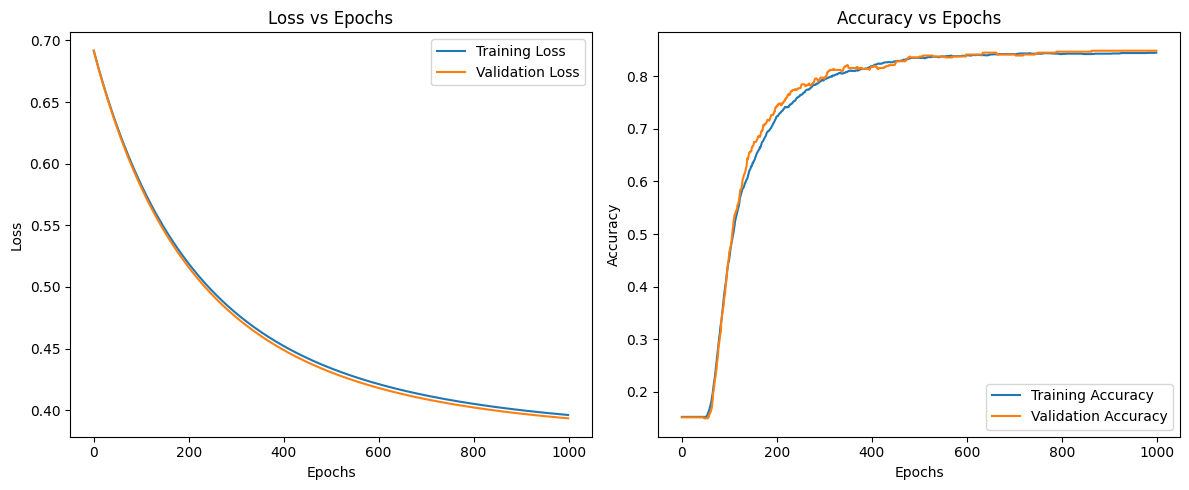

In [11]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)
model = LogisticRegression(alpha=0.01, epochs=1000, method='BGD')
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values)

**Observations**:- From the graphs we can can observe that our loss is constantly decreasing with each iteration and our accuracy is increasing with each iteration. Also, the model is converged quickly at around 700 iterations. And performing well on training and validation set.

### Part B

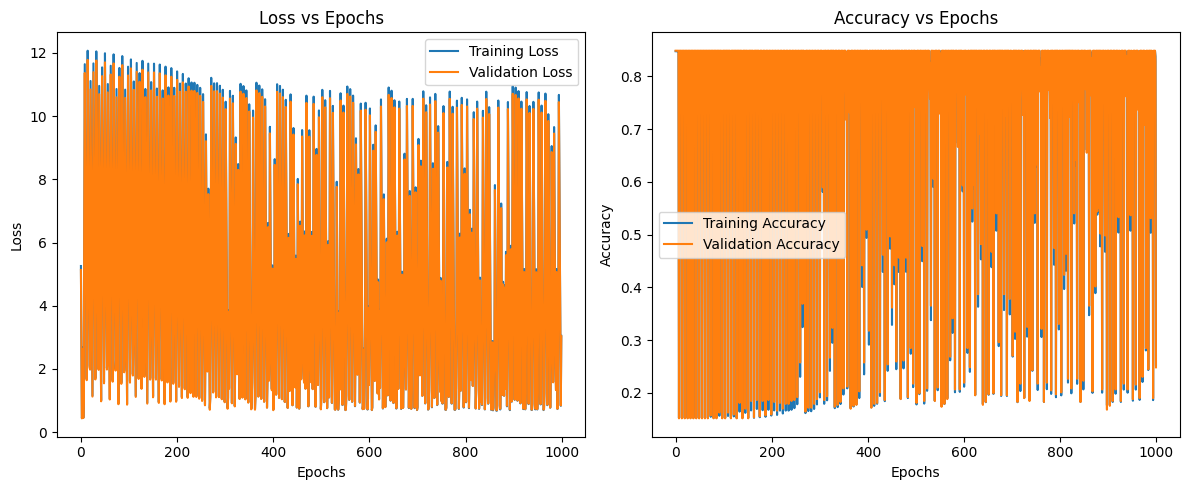

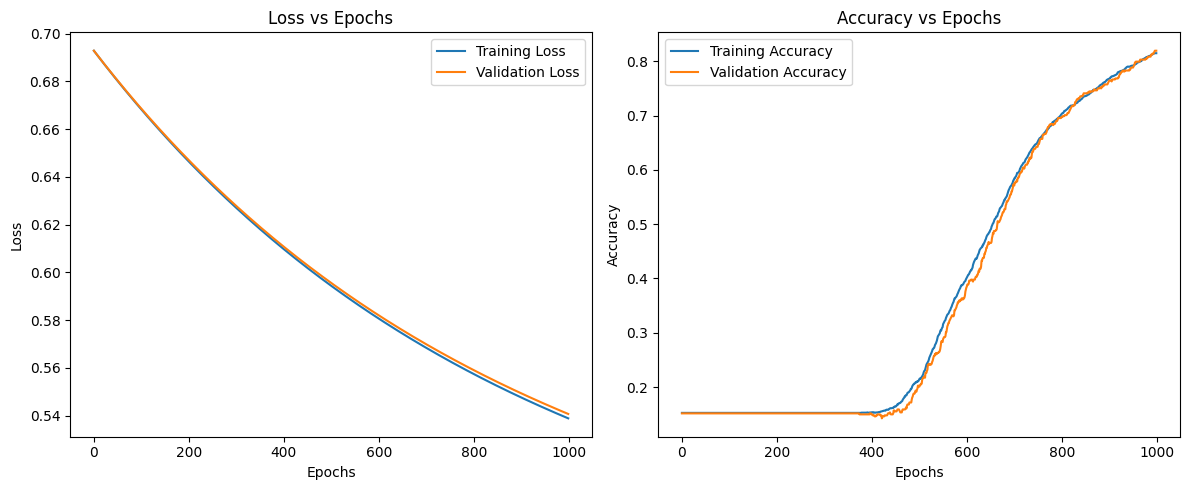



Test Accuracy: 0.8179




In [12]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(df.drop('HeartDisease', axis=1), df['HeartDisease'])
model = LogisticRegression(alpha=0.001, epochs=1000, method='BGD')
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values)

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(df.drop('HeartDisease', axis=1), df['HeartDisease'], scaling = "min_max")
model = LogisticRegression(alpha=0.001, epochs=1000, method='BGD')
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values)

y_pred = model.predict(X_test.values)
accuracy = model.accuracy(X_test.values, Y_test.values)
print(f"\n\n\033[1;34mTest Accuracy: \033[1;92m{accuracy:.4f}\033[0m\n\n")

**Observations**:- From the above two graphs we can conclude that without any scaling the model is performing very poorly and both loss and acuracy are very fluctuating and model is also not converging. But after applying "min-max" scaling the model is performing very well, both loss and accuracy are constantly decreasing and increasing respectively with each iteration and finally model get converged also.

### Part C

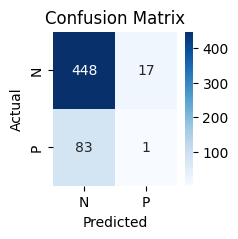




True  Positives (TP): 1
True  Negatives (TN): 448
False Positives (FP): 17
False Negatives (FN): 83


Precision: 0.0556
Recall   : 0.0119
F1 Score : 0.0196
ROC-AUC Score: 0.3110




In [13]:
def display_stats(model, X_val, Y_val, show_matrix = True):
    y_pred_val = model.predict(X_val.values)

    confusionn_matrix = confusion_matrix(Y_val.values, y_pred_val)

    if show_matrix:
        plt.figure(figsize=(2, 2))
        sns.heatmap(confusionn_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'P'], yticklabels=['N', 'P'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    print("\n\n")
    print(f"True  Positives (TP): {confusionn_matrix[1, 1]}")
    print(f"True  Negatives (TN): {confusionn_matrix[0, 0]}")
    print(f"False Positives (FP): {confusionn_matrix[0, 1]}")
    print(f"False Negatives (FN): {confusionn_matrix[1, 0]}")

    print(f"\n\n\033[1;34mPrecision: \033[1;92m{precision_score(Y_val.values, y_pred_val):.4f}\033[0m")
    print(f"\033[1;34mRecall   : \033[1;92m{recall_score(Y_val.values, y_pred_val):.4f}\033[0m")
    print(f"\033[1;34mF1 Score : \033[1;92m{f1_score(Y_val.values, y_pred_val):.4f}\033[0m")
    print(f"\033[1;34mROC-AUC Score: \033[1;92m{roc_auc_score(Y_val.values, sigmoid(np.dot(X_val.values, model.weights) + model.bias)):.4f}\033[0m\n\n")


display_stats(model, X_test, Y_test)

**Observations**:-

1.   The model shows very poor performance in identifying the positive class, as reflected by the very low recall (1.2%) and precision (5.56%). This indicate class imbalance, where the negative class dominates the dataset, causing the model to focus on predicting negatives.
2.   With 82 false negatives, the model is missing most of the actual positive instances.
3. Low ROC-AUC and F1 Scores also indicates the imbalance of classes in dataset.



### Part D - SGD

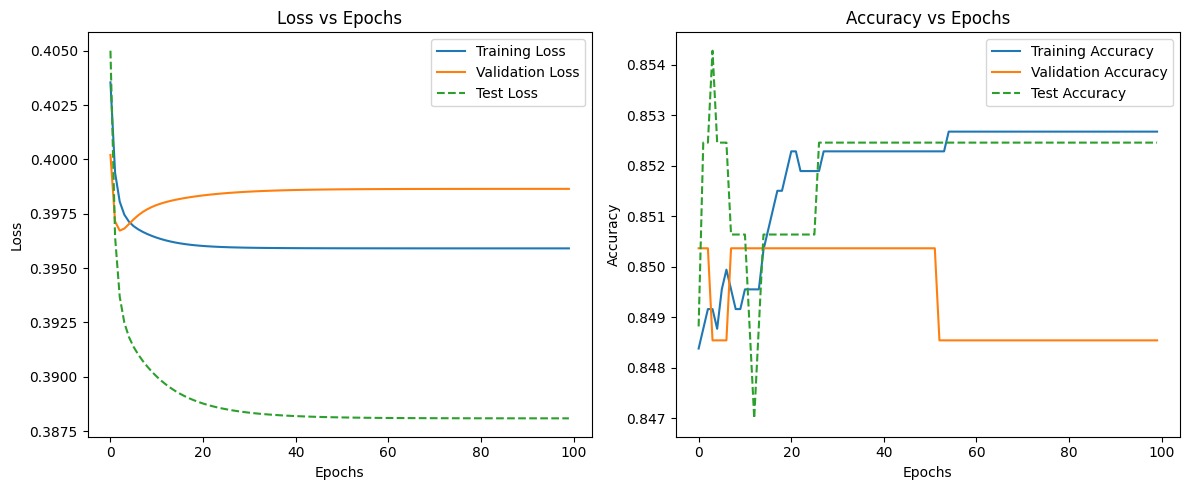



Test Accuracy: 0.8525




In [14]:
model = LogisticRegression(alpha=0.1, epochs=100, method='SGD')
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values, X_test.values, Y_test.values)

y_pred = model.predict(X_test.values)
accuracy = model.accuracy(X_test.values, Y_test.values)
print(f"\n\n\033[1;34mTest Accuracy: \033[1;92m{accuracy:.4f}\033[0m\n\n")

### Part D - MBGD - 64

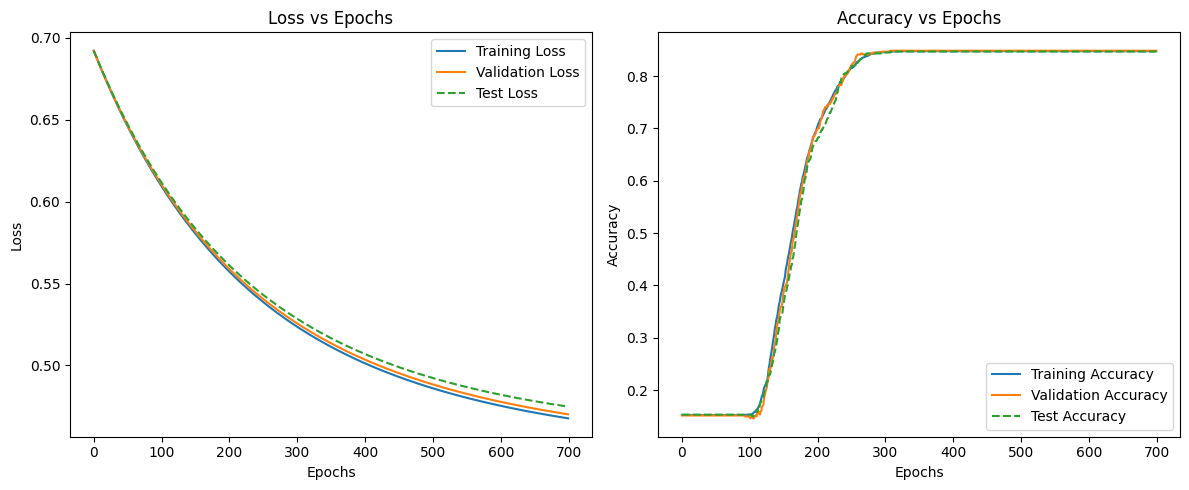



Test Accuracy: 0.8469945355




In [15]:
model = LogisticRegression(alpha=0.0001, epochs=700, method='MBGD', batch_size=64)
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values, X_test.values, Y_test.values)

y_pred = model.predict(X_test.values)
accuracy = model.accuracy(X_test.values, Y_test.values)
print(f"\n\n\033[1;34mTest Accuracy: \033[1;92m{accuracy:.10f}\033[0m\n\n")

### Part D - MBGD - 128

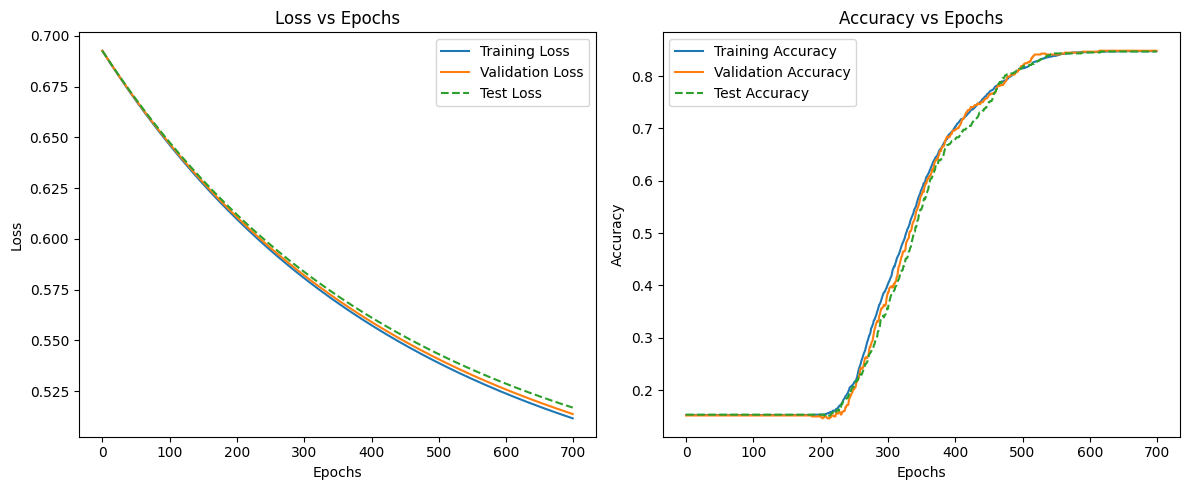



Test Accuracy: 0.8469945355




In [16]:
model = LogisticRegression(alpha=0.0001, epochs=700, method='MBGD', batch_size=128)
model.fit(X_train.values, Y_train.values, X_val.values, Y_val.values, X_test.values, Y_test.values)

y_pred = model.predict(X_test.values)
accuracy = model.accuracy(X_test.values, Y_test.values)
print(f"\n\n\033[1;34mTest Accuracy: \033[1;92m{accuracy:.10f}\033[0m\n\n")

**Observation**:- From the previous three pairs of Graphs i.e Stochastic Gradient Descent(SGD), Mini-Batch Gradient Descent-64(MBGD-64) and Mini-Batch Gradient Descent-128(MBGD-128). We come to the conclusion that:-  

1.   SGD converges fast as compared to others because it will do more number of updates in a single iteration.
2.   As compared to SGD both MBGD-64 and MBGD-128 have much smoother convergence.
3. For same number of iterations and learning-rate, MBGD-64 took less number of iteration to converge are compared to MBGD-128 due to its smaller batch size.
4. In Terms of stability MBGD-128 is much stable that the other two.

  

### Part E - K-Fold Function

In [17]:
def k_fold(X, Y, k):

    n = len(X)
    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)

    for fold in range(k):
        val_indices = indices[fold * fold_size: (fold + 1) * fold_size]
        train_indices = np.delete(indices, np.arange(fold * fold_size, (fold + 1) * fold_size))

        X_train, X_val = X[train_indices], X[val_indices]
        Y_train, Y_val = Y[train_indices], Y[val_indices]

        yield X_train, X_val, Y_train, Y_val

### Part E

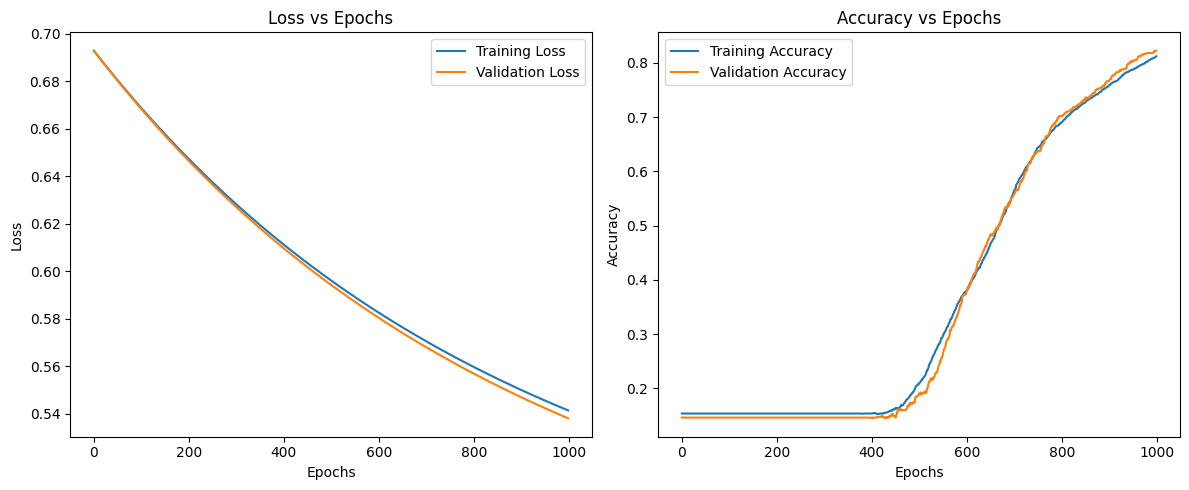

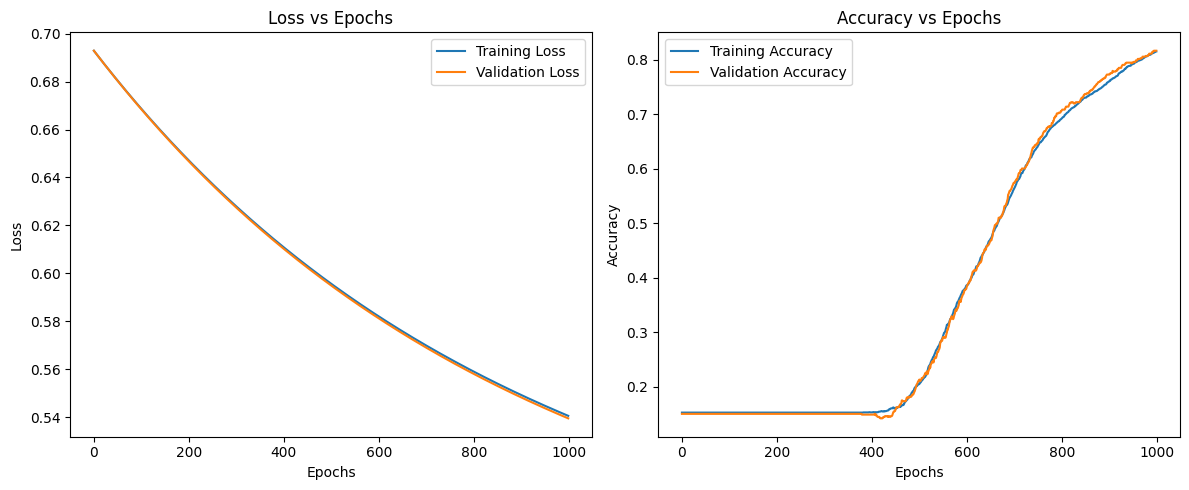

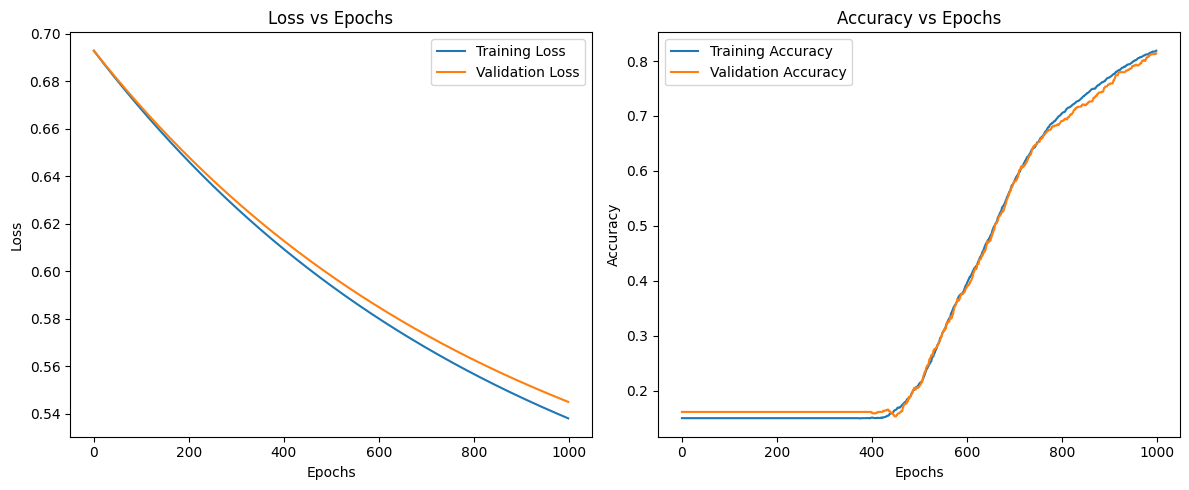

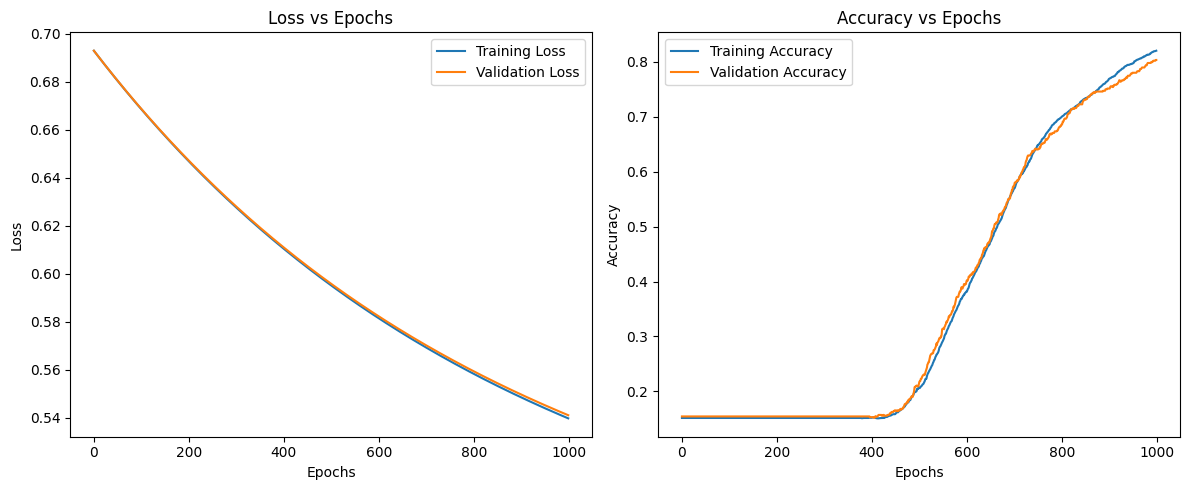

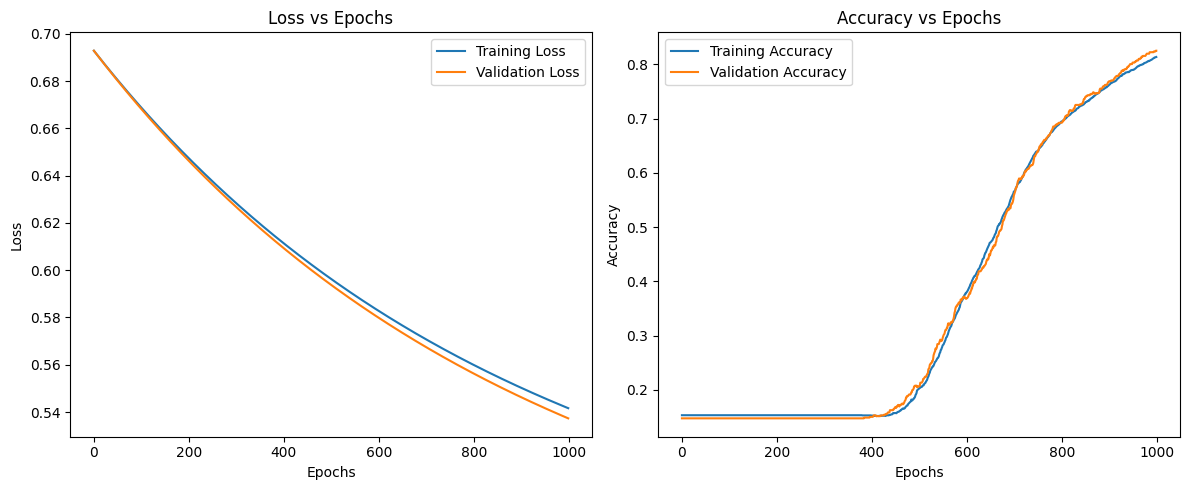



K-Fold Cross-Validation Average Results (k=5):

Accuracy:    Mean = 0.8161, Std = 0.0076
Precision:   Mean = 0.0414, Std = 0.0233
Recall:      Mean = 0.0091, Std = 0.0058
F1 Score:    Mean = 0.0148, Std = 0.0092


K-Stability and Variance:

- Accuracy variance:  0.0001
- Precision variance: 0.0005
- Recall variance:    0.0000
- F1 Score variance:  0.0001



In [18]:
f1_scores = []
recall_scores = []
accuracy_scores = []
precision_scores = []

X = min_max_scaler(X)

for X_train, X_val, Y_train, Y_val in k_fold(X.values, Y.values, 5):
    model = LogisticRegression(alpha=0.001, epochs=1000)
    model.fit(X_train, Y_train, X_val, Y_val)

    y_pred = model.predict(X_val)

    accuracy_scores.append(accuracy_score(Y_val, y_pred))
    precision_scores.append(precision_score(Y_val, y_pred))
    recall_scores.append(recall_score(Y_val, y_pred))
    f1_scores.append(f1_score(Y_val, y_pred))


print(f"\n\n\033[1;34mK-Fold Cross-Validation Average Results (k=5):\033[0m\n")
print(f"\033[1;34mAccuracy\033[0m:    Mean = \033[1;92m{np.mean(accuracy_scores):.4f}\033[0m, Std = \033[1;92m{np.std(accuracy_scores):.4f}\033[0m")
print(f"\033[1;34mPrecision\033[0m:   Mean = \033[1;92m{np.mean(precision_scores):.4f}\033[0m, Std = \033[1;92m{np.std(precision_scores):.4f}\033[0m")
print(f"\033[1;34mRecall\033[0m:      Mean = \033[1;92m{np.mean(recall_scores):.4f}\033[0m, Std = \033[1;92m{np.std(recall_scores):.4f}\033[0m")
print(f"\033[1;34mF1 Score\033[0m:    Mean = \033[1;92m{np.mean(f1_scores):.4f}\033[0m, Std = \033[1;92m{np.std(f1_scores):.4f}\033[0m\n")

print(f"\n\033[1;34mK-Stability and Variance:\033[0m\n")
print(f"\033[1;34m- Accuracy variance\033[0m:  \033[1;92m{np.var(accuracy_scores):.4f}\033[0m")
print(f"\033[1;34m- Precision variance\033[0m: \033[1;92m{np.var(precision_scores):.4f}\033[0m")
print(f"\033[1;34m- Recall variance\033[0m:    \033[1;92m{np.var(recall_scores):.4f}\033[0m")
print(f"\033[1;34m- F1 Score variance\033[0m:  \033[1;92m{np.var(f1_scores):.4f}\033[0m\n")

**Observations**:- From the Graph and average of metrics we can conclude that the model's performance is relatively stable and consistent across different folds, with low variances and small standard deviations. This suggests that the model is robust and can generalize well to new, unseen data.

### Part F

In [19]:
def show_table(combinations, early, no_early):
    headers = ["α", "Regularization", "λ", "Accuracy (ES/NO-ES)", "Precision (ES/NO-ES)", "Recall (ES/NO-ES)", "F1 (ES/NO-ES)"]

    table = []
    early = {k: [round(value, 4) for value in v] for k, v in early.items()}
    no_early = {k: [round(value, 4) for value in v] for k, v in no_early.items()}

    for i, (alpha, regularization, lmbda) in enumerate(combinations):
        row = [alpha, regularization, lmbda]
        row.extend([(early['accuracy'][i], no_early['accuracy'][i]), (early['precision'][i], no_early['precision'][i]), (early['recall'][i], no_early['recall'][i]), (early['f1'][i], no_early['f1'][i])])
        table.append(row)

    print("\n\n")
    print(tabulate(table, headers, tablefmt="grid"))
    print("\n\n")



Early Stopping at Epoch 10




Early Stopping at Epoch 11




Early Stopping at Epoch 29




Early Stopping at Epoch 90




Early Stopping at Epoch 10




Early Stopping at Epoch 11




Early Stopping at Epoch 30




Early Stopping at Epoch 98




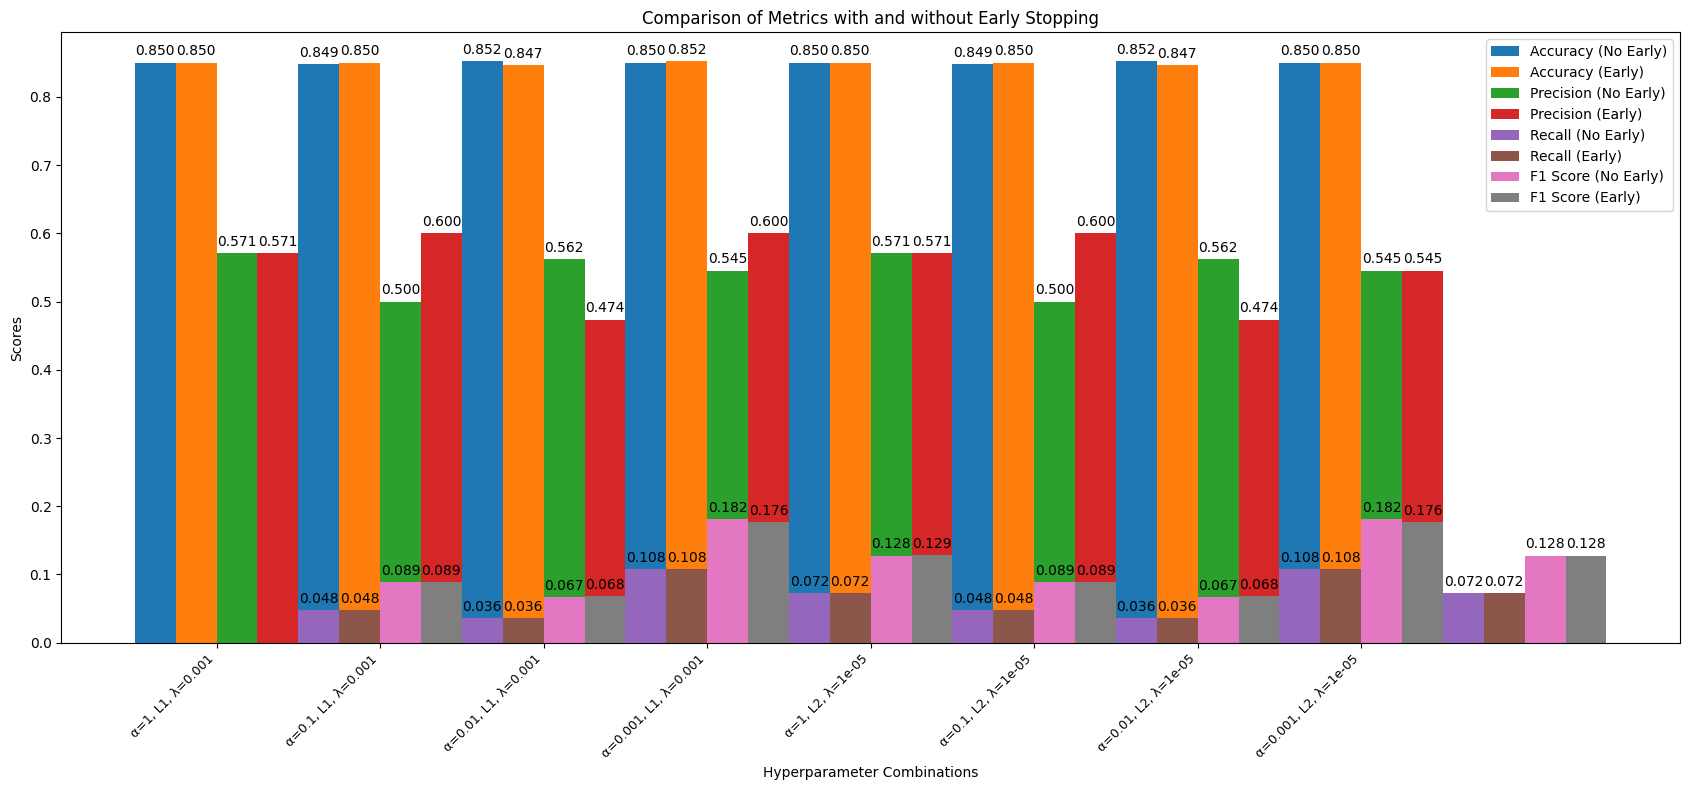




+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
|     α | Regularization   |     λ | Accuracy (ES/NO-ES)   | Precision (ES/NO-ES)   | Recall (ES/NO-ES)   | F1 (ES/NO-ES)    |
+=======+==================+=======+=======================+========================+=====================+==================+
| 1     | L1               | 0.001 | (0.8504, 0.8504)      | (0.5714, 0.5714)       | (0.0482, 0.0482)    | (0.0889, 0.0889) |
+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
| 0.1   | L1               | 0.001 | (0.8504, 0.8485)      | (0.6, 0.5)             | (0.0361, 0.0361)    | (0.0682, 0.0674) |
+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
| 0.01  | L1               | 0.001 | (0.8467, 0.8522)      | (0.4737, 0.5625)       | (0.1084, 0.1084)    | 

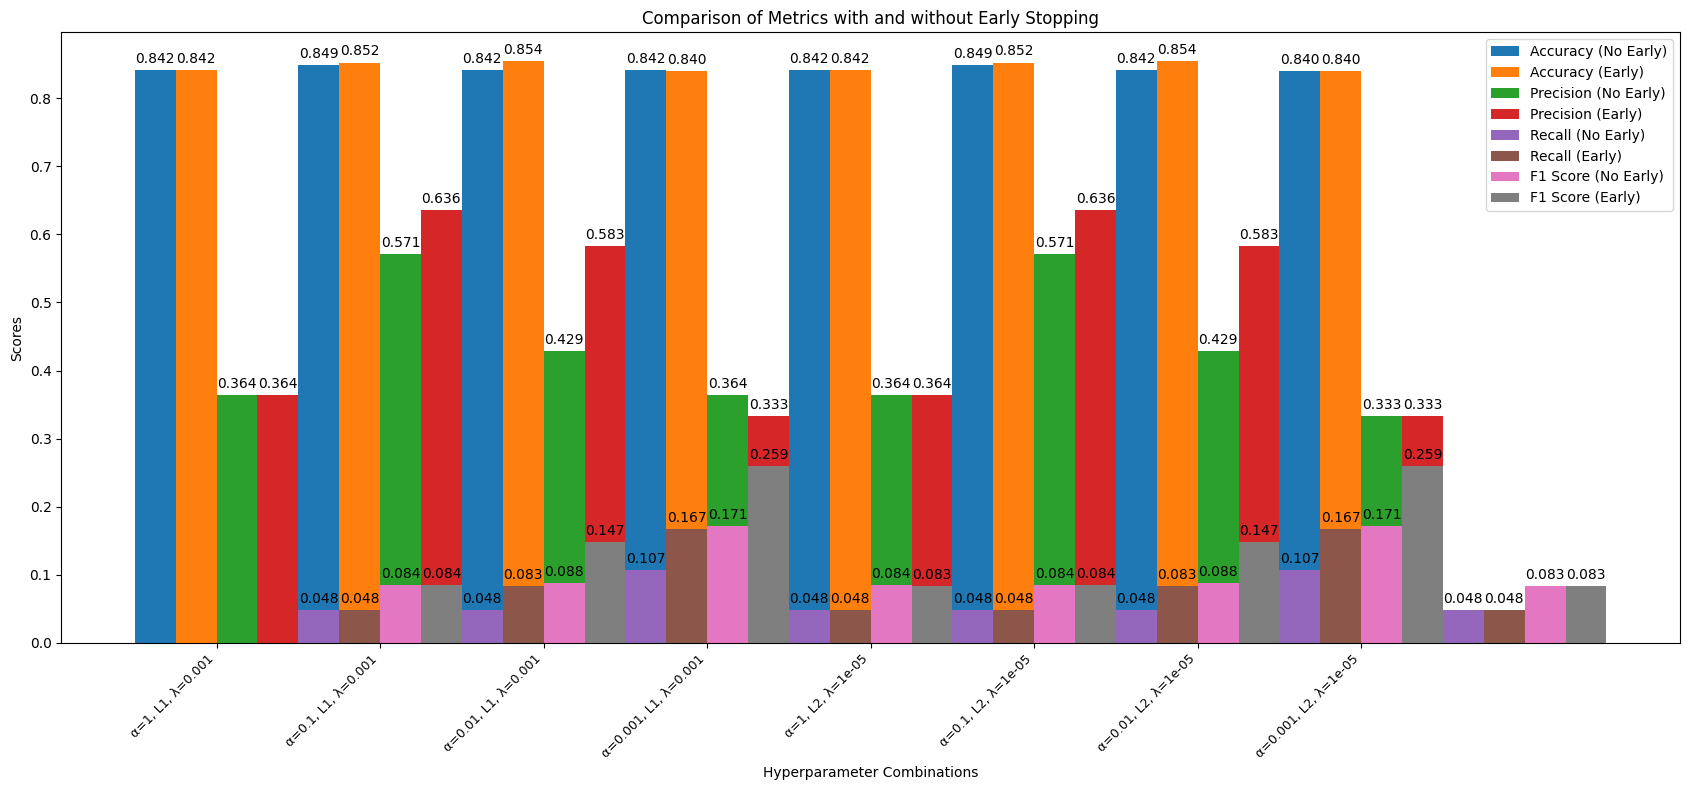




+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
|     α | Regularization   |     λ | Accuracy (ES/NO-ES)   | Precision (ES/NO-ES)   | Recall (ES/NO-ES)   | F1 (ES/NO-ES)    |
+=======+==================+=======+=======================+========================+=====================+==================+
| 1     | L1               | 0.001 | (0.8415, 0.8415)      | (0.3636, 0.3636)       | (0.0476, 0.0476)    | (0.0842, 0.0842) |
+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
| 0.1   | L1               | 0.001 | (0.8525, 0.8488)      | (0.6364, 0.5714)       | (0.0833, 0.0476)    | (0.1474, 0.0879) |
+-------+------------------+-------+-----------------------+------------------------+---------------------+------------------+
| 0.01  | L1               | 0.001 | (0.8543, 0.8415)      | (0.5833, 0.4286)       | (0.1667, 0.1071)    | 

In [20]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y, scaling = "min_max")
combinations = [(1, "L1", 1e-3), (0.1, "L1", 1e-3), (0.01, "L1", 1e-3), (0.001, "L1", 1e-3), (1, "L2", 1e-5), (0.1, "L2", 1e-5), (0.01, "L2", 1e-5), (0.001, "L2", 1e-5)]

labels = []
earlyV = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
no_earlyV = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
earlyT = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
no_earlyT = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for alpha, regularization, lmbda in combinations:
    model_early = LogisticRegression(alpha=alpha, epochs=100, method='SGD', early_stopping=True, patience=10, min_delta=1e-3, regularization=regularization, lmbda=lmbda, graphs=False)
    model_early.fit(X_train.values, Y_train.values, X_val.values, Y_val.values)

    y_pred_early = model_early.predict(X_test.values)
    earlyT['accuracy'].append(accuracy_score(Y_test.values, y_pred_early))
    earlyT['precision'].append(precision_score(Y_test.values, y_pred_early))
    earlyT['recall'].append(recall_score(Y_test.values, y_pred_early))
    earlyT['f1'].append(f1_score(Y_test.values, y_pred_early))

    y_pred_early = model_early.predict(X_val.values)
    earlyV['accuracy'].append(accuracy_score(Y_val.values, y_pred_early))
    earlyV['precision'].append(precision_score(Y_val.values, y_pred_early))
    earlyV['recall'].append(recall_score(Y_val.values, y_pred_early))
    earlyV['f1'].append(f1_score(Y_val.values, y_pred_early))

    model_no_early = LogisticRegression(alpha=alpha, epochs=100, method='SGD', early_stopping=False, patience=10, min_delta=1e-3, regularization=regularization, lmbda=lmbda, graphs=False)
    model_no_early.fit(X_train.values, Y_train.values, X_val.values, Y_val.values)

    y_pred_no_early = model_no_early.predict(X_test.values)
    no_earlyT['accuracy'].append(accuracy_score(Y_test.values, y_pred_no_early))
    no_earlyT['precision'].append(precision_score(Y_test.values, y_pred_no_early))
    no_earlyT['recall'].append(recall_score(Y_test.values, y_pred_no_early))
    no_earlyT['f1'].append(f1_score(Y_test.values, y_pred_no_early))

    y_pred_no_early = model_no_early.predict(X_val.values)
    no_earlyV['accuracy'].append(accuracy_score(Y_val.values, y_pred_no_early))
    no_earlyV['precision'].append(precision_score(Y_val.values, y_pred_no_early))
    no_earlyV['recall'].append(recall_score(Y_val.values, y_pred_no_early))
    no_earlyV['f1'].append(f1_score(Y_val.values, y_pred_no_early))

    labels.append(f'α={alpha}, {regularization}, λ={lmbda}')

show_metrics(no_earlyV, earlyV, labels)
show_table(combinations, earlyV, no_earlyV)

show_metrics(earlyT, no_earlyT, labels)
show_table(combinations, no_earlyT, earlyT)

**Observation**:- To prevent Overfitting I choose early stopping parameter as *patience=10* and *min_delta=1e-3*. This means that training will stop if the validation loss does not improve by at least 1e-3 for 10 consecutive epochs.

After Trying eight different combinations of learning rate (α) = {1, 0.1, 0.01, 0.001} and L1, L2 regularization. I come to the conclusion that early stopping stops the overfitting and promotes the generalization of the unseen test data. As it will be clearly visible in the metrics data. From all combinantions models in which early stopping is enabled, has better accuracy, precison, recall and f1-score.